<a href="https://colab.research.google.com/github/IgnacioIbanezSala/Forecasting/blob/main/LoadLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow import keras
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
import math
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from copy import deepcopy as dc
from google.colab import files

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
data = pd.read_csv("data.csv")
print(data.head())
print(data.info())
print(data.describe())

   Unnamed: 0         EAST        WEST       NORTH         COAST
0           0  1302.296674  973.455700  757.843076  12054.939199
1           1  1259.355201  959.775908  737.236591  11793.290315
2           2  1210.287905  941.112359  725.610502  11460.841252
3           3  1179.311517  920.373708  717.420214  11244.980243
4           4  1171.841803  918.203309  719.178247  11073.085585
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  8760 non-null   int64  
 1   EAST        8760 non-null   float64
 2   WEST        8760 non-null   float64
 3   NORTH       8760 non-null   float64
 4   COAST       8760 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 342.3 KB
None
        Unnamed: 0         EAST         WEST        NORTH         COAST
count  8760.000000  8760.000000  8760.000000  8760.000000   8760.000000
mean   4379.5000

In [ ]:
data

,Unnamed: 0,EAST,WEST,NORTH,COAST
0,0,1302.296674,973.455700,757.843076,12054.939199
1,1,1259.355201,959.775908,737.236591,11793.290315
2,2,1210.287905,941.112359,725.610502,11460.841252
3,3,1179.311517,920.373708,717.420214,11244.980243
4,4,1171.841803,918.203309,719.178247,11073.085585
...,...,...,...,...,...
8755,8755,1407.683729,1125.338906,938.901362,10247.562908
8756,8756,1362.637978,1103.919231,963.913723,9887.676773
8757,8757,1327.298817,1084.122587,949.798259,9572.382483
8758,8758,1237.913479,1058.601615,928.929373,9258.586996


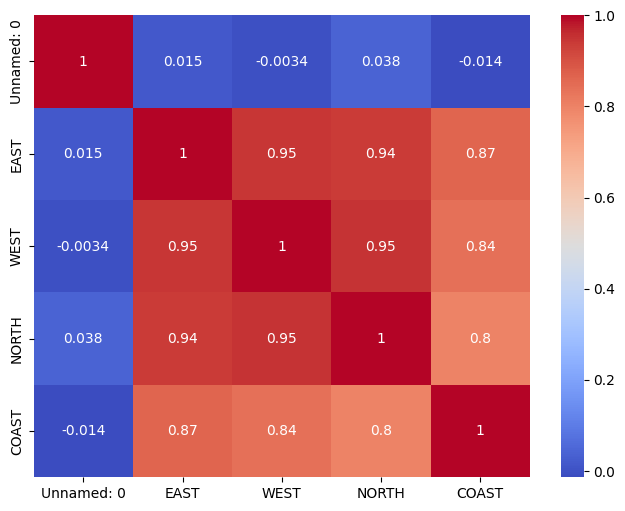

In [ ]:
numeric_data = data.select_dtypes(include = ["int64", "float64"])

plt.figure(figsize=(8,6))
sns.heatmap(numeric_data.corr(), annot=True, cmap="coolwarm")
plt.show()


In [ ]:
east_load = data.filter(["EAST"])
dataset = east_load.values

In [ ]:
percent_to_train = 95 #@param {type:"integer"}
training_data_len = int(np.ceil(len(dataset))*(percent_to_train/100))
print("Data to use for training: ", training_data_len)
print("Data to use for testing: ", (len(dataset) - training_data_len))

Data to use for training:  8322
Data to use for testing:  438


## KERAS LSTM CELL STRUCTURE

## <img src="https://github.com/kmkarakaya/ML_tutorials/blob/master/images/LSTM_internal2.png?raw=true" width="700">

* LSTM ***expects*** **input data** to be a **3D** tensor such that:

      [batch_size, timesteps, feature]

* **batch_size** how many samples in each batch during training and testing

* **timesteps** means how many values exist in a sequence. For example in [4, 7, 8, 4] there are 4 timesteps

* **features**: how many dimensions are used to represent a data in one time step.

In [ ]:
#@title Configure problem

n_timesteps_in = 200  #@param {type:"integer"}
#each input sample has 60 values

n_features = 1   #@param {type:"integer"}
#each value is one number


In [ ]:
def create_dataset(dataset, n_timesteps_in, n_features):
  X, Y = [], []
  for i in range(n_timesteps_in, len(dataset)-10):
    X.append(training_data[i-n_timesteps_in:i, 0])
    Y.append(training_data[i:i+10,0])
  X, Y = np.array(X), np.array(Y)
  X = np.reshape(X, (X.shape[0], X.shape[1], n_features))
  Y = np.reshape(Y, (Y.shape[0], Y.shape[1], 1))
  return torch.tensor(X).float(), torch.tensor(Y).float()

In [ ]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dataset)

training_data = scaled_data[:training_data_len]
X_train, Y_train = create_dataset(training_data, n_timesteps_in, n_features)

print(X_train.shape)

print(Y_train.shape)


torch.Size([8112, 200, 1])
torch.Size([8112, 10, 1])


In [ ]:
test_data = scaled_data[(training_data_len - n_timesteps_in):]

X_test, Y_test = create_dataset(test_data, n_timesteps_in, n_features)

print(X_test.shape)
print(Y_test.shape)

torch.Size([428, 200, 1])
torch.Size([428, 10, 1])


In [ ]:
class TimeSeriesDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, i):
    return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, Y_train)
test_dataset = TimeSeriesDataset(X_test, Y_test)

## Roll-Out Representation of LSTM for each Time Step

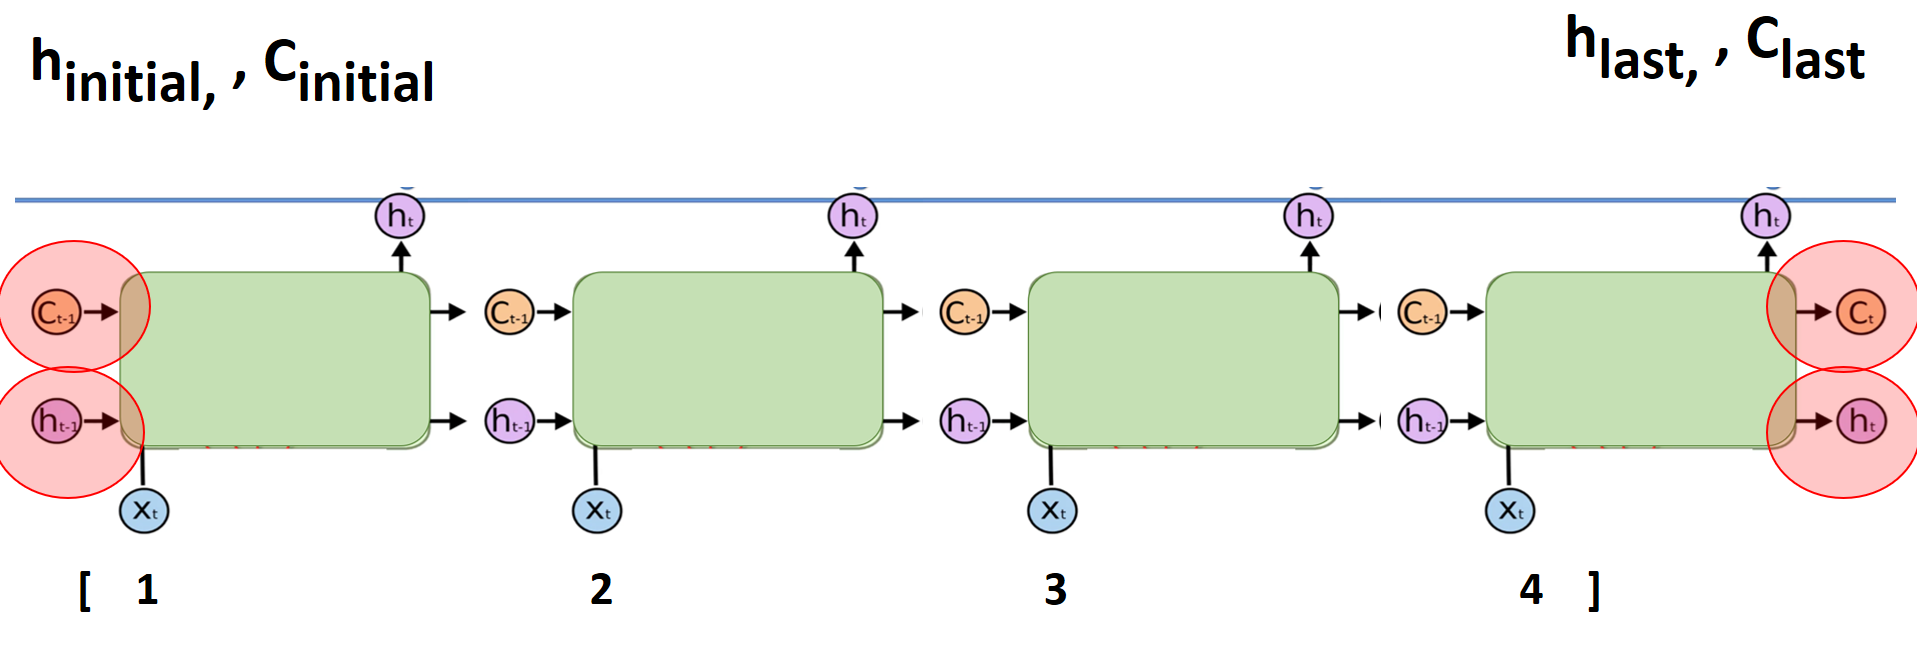

## Simple pseudocode representation of an LSTM cell and layer

    def LSTMcell(input)
    {
      ct = random()
      ht = f(input, ct)
      return ht, ct
    }

    def LSTMlayer(sequence)
    {
      ht, ct = random()
      for xt in sequence:
        ht, ct = LSTMcell(xt, ht, ct)
      return ht, ct
    }

**Note** thath in reality there is only one cell replicating itself

* **epochs** an arbitrary cutoff, generally defined as "one pass over the entire dataset", used to separate training into distinct phases, which is useful for logging and periodic evaluation

* **batch_size** a set of N samples. The samples in a batch are processed independently, in parallel. If training, a batch results in only one update to the model. A batch generally approximates the distribution of the input data better than a single input. The larger the batch, the better the approximation; however, it is also true that the batch will take longer to process and will still result in only one update. For inference (evaluate/predict), it is recommended to pick a batch size that is as large as you can afford without going out of memory (since larger batches will usually result in faster evaluation/prediction).

* **step**: $int\left(\frac{Total\,Samples}{batch\,size}\right)$

In [ ]:
epochs = 20 #@param {type:"integer"}
total_samples = X_train.shape[0]
batch_size = 32 #@param {type:"integer"}
steps_num = math.ceil(total_samples/batch_size)
print("Steps: ", steps_num)

Steps:  254


In [ ]:
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

In [ ]:
for _, batch in enumerate(train_loader):
  x_batch, y_batch = batch[0].to(device), batch[1].to(device)
  print(x_batch.shape, y_batch.shape)
  break


torch.Size([32, 200, 1]) torch.Size([32, 10, 1])


In [ ]:
class LSTM_sl(nn.Module):
  def __init__(self, input_size, hidden_size, num_stacked_layers, lr):
    super().__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_stacked_layers = num_stacked_layers

    self.layer_1 = nn.LSTM(input_size=input_size,
                           hidden_size=hidden_size,
                           batch_first=True,
                           num_layers=num_stacked_layers
                           )
    self.layer_2 = nn.Linear(hidden_size, 10)

    self.optimizer = torch.optim.Adam(self.parameters(), lr)
    # The best loss function to use depends on the problem.
    # We will see a different loss function later for probabilistic
    # forecasting
    self.loss_function = nn.L1Loss()

  def forward(self, x):
    batch_size = x.size(0)
    h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device) #(n_layers, batch_size, hidden_size)
    c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device) #(n_layers, batch_size, hidden_size)
    out, (h0, c0) = self.layer_1(x, (h0, c0))
    out = self.layer_2(out[:,-1,:])
    out = out.reshape(out.shape[0], out.shape[1], 1)
    return out

  def compute_loss(self, outputs, targets):
      loss = self.loss_function(outputs, targets)
      return loss

  def optimize(self, outputs, targets):
      self.optimizer.zero_grad()
      loss = self.compute_loss(outputs, targets)
      loss.backward()
      self.optimizer.step()

In [ ]:
class LSTM_cell(nn.Module):
  def __init__(self, input_size, hidden_size):
    super().__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.lstm_1 = nn.LSTMCell(input_size, hidden_size)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    batch_size = x.shape[0]
    h0 = torch.zeros(batch_size, self.hidden_size).to(device) #(batch_size, hidden_size)
    c0 = torch.zeros(batch_size, self.hidden_size).to(device) #(batch_size, hidden_size)

    for t in range(x.shape[1]):
      h0, c0 = self.lstm_1(x[:,t,:], (h0, c0))

    out = self.fc(h0)
    out = out.reshape(out.shape[0], out.shape[1], 1)
    return out

In [ ]:
learning_rate = 0.01

#model = LSTM_cell(1,200)
#model.to(device)
model_sl = LSTM_sl(1,200,1,learning_rate)
model_sl.to(device)
model_2 = LSTM_sl(1,200,1,0.001)
model_2.to(device)
model_3 = LSTM_sl(1,200,1,0.0001)
model_3.to(device)


#print(model)
print(model_sl)


LSTM_sl(
  (layer_1): LSTM(1, 200, batch_first=True)
  (layer_2): Linear(in_features=200, out_features=10, bias=True)
  (loss_function): L1Loss()
)


In [ ]:
def train_one_epoch(model, train_loader, device):
  model.train(True)
  print(f'Epoch {epoch +1}')
  running_loss = 0.0
  loss_values = []
  for batch_indx, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)

    output = model(x_batch)
    loss = model.compute_loss(output, y_batch)
    running_loss += loss.item()
    model.optimize(output, y_batch)


    if batch_indx % 100 == 99:
      avg_loss_across_batches = running_loss / 100
      print('Batch {0}, Loss {1:.3f}'.format(batch_indx+1, avg_loss_across_batches))
      running_loss = 0.0

  loss_values = running_loss / len(train_loader)
  print()
  return loss_values


In [ ]:
def validate_one_epoch(model, test_loader, device):
  model.train(False)
  running_loss = 0.0
  loss_values = []
  for batch_indx, batch in enumerate(test_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)

    with torch.no_grad():
      output = model(x_batch)
      loss = model.compute_loss(output, y_batch)
      running_loss += loss

  avg_loss_across_batches = running_loss / len(test_loader)

  print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
  print('***************************************************')
  print()
  return avg_loss_across_batches


In [ ]:
train_loss_values = []
validate_loss_values = []
train_loss_values_2 = []
validate_loss_values_2 = []
train_loss_values_3 = []
validate_loss_values_3 = []
for epoch in range(epochs):
  loss_values_epoch = train_one_epoch(model_sl, train_loader, device)
  train_loss_values.append(loss_values_epoch)
  val_loss_values_epoch = validate_one_epoch(model_sl, test_loader, device)
  validate_loss_values.append(val_loss_values_epoch)

  loss_values_epoch = train_one_epoch(model_2, train_loader, device)
  train_loss_values_2.append(loss_values_epoch)
  val_loss_values_epoch = validate_one_epoch(model_2, test_loader, device)
  validate_loss_values_2.append(val_loss_values_epoch)

  loss_values_epoch = train_one_epoch(model_3, train_loader, device)
  train_loss_values_3.append(loss_values_epoch)
  val_loss_values_epoch = validate_one_epoch(model_3, test_loader, device)
  validate_loss_values_3.append(val_loss_values_epoch)


Epoch 1
Batch 100, Loss 0.582
Batch 200, Loss 0.345

Val Loss: 0.407
***************************************************

Epoch 1
Batch 100, Loss 0.666
Batch 200, Loss 0.367

Val Loss: 0.453
***************************************************

Epoch 1
Batch 100, Loss 0.754
Batch 200, Loss 0.683

Val Loss: 0.552
***************************************************

Epoch 2
Batch 100, Loss 0.274
Batch 200, Loss 0.320

Val Loss: 0.398
***************************************************

Epoch 2
Batch 100, Loss 0.276
Batch 200, Loss 0.268

Val Loss: 0.450
***************************************************

Epoch 2
Batch 100, Loss 0.638
Batch 200, Loss 0.606

Val Loss: 0.559
***************************************************

Epoch 3
Batch 100, Loss 0.248
Batch 200, Loss 0.230

Val Loss: 0.345
***************************************************

Epoch 3
Batch 100, Loss 0.251
Batch 200, Loss 0.259

Val Loss: 0.433
***************************************************

Epoch 3
Batch 100, Loss 

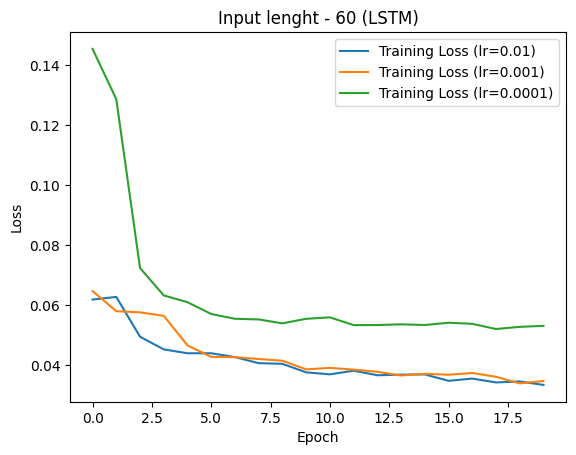

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
plt.plot(train_loss_values, label='Training Loss (lr=0.01)')
plt.plot(train_loss_values_2, label='Training Loss (lr=0.001)')
plt.plot(train_loss_values_3, label='Training Loss (lr=0.0001)')
#plt.plot(validate_loss_values, label='Validation Loss')
plt.title("Input lenght - 60 (LSTM)")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('LoadLSTM60lr.png')
plt.show()
files.download("LoadLSTM60lr.png")

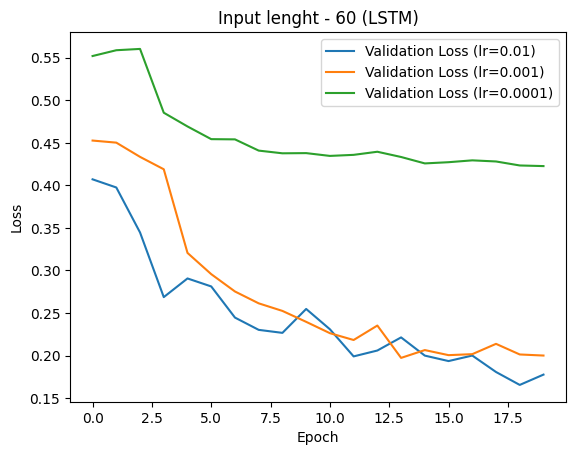

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
plt.plot(validate_loss_values, label='Validation Loss (lr=0.01)')
plt.plot(validate_loss_values_2, label='Validation Loss (lr=0.001)')
plt.plot(validate_loss_values_3, label='Validation Loss (lr=0.0001)')
plt.title("Input lenght - 60 (LSTM)")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('LoadLSTM60Vallr.png')
plt.show()
files.download("LoadLSTM60Vallr.png")

(82520,)


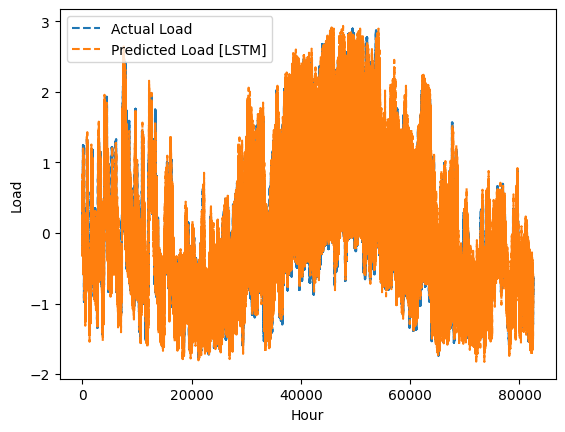

In [ ]:
with torch.no_grad():
  #predicted = model(X_train.to(device)).to('cpu').numpy().flatten()
  predicted_sl = model_sl(X_train.to(device)).to('cpu').numpy().flatten()

train_data = Y_train.numpy().flatten()
print(predicted_sl.shape)
plt.plot(train_data, ls='--', label='Actual Load')
plt.plot(predicted_sl, ls='--', label='Predicted Load [LSTM]')


plt.xlabel('Hour')
plt.ylabel('Load')
plt.legend()
plt.show()

/tmp/ipython-input-3682606209.py:12: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  dummies[:, 0] = Y_test.flatten()


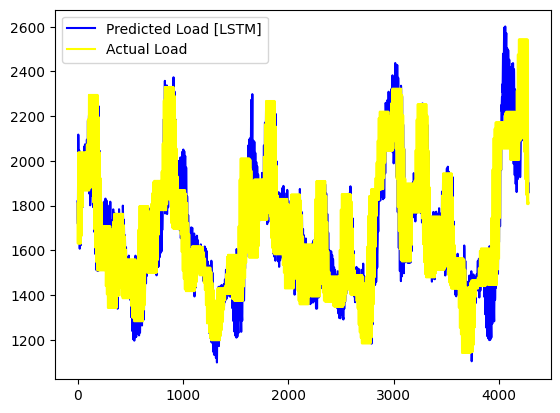

In [ ]:
with torch.no_grad():
  #test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()
  test_predictions_sl = model_sl(X_test.to(device)).detach().cpu().numpy().flatten()


dummies = np.zeros((test_predictions_sl.shape[0], 100+1))
dummies[:, 0] = test_predictions_sl
dummies = scaler.inverse_transform(dummies)
test_predictions = dc(dummies[:, 0])

dummies = np.zeros((test_predictions.shape[0], 100+1))
dummies[:, 0] = Y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])

#plt.plot(test_predictions, label='Predicted Close [LSTMCell]', color='orange')
plt.plot(test_predictions, label="Predicted Load [LSTM]", color ='blue')
plt.plot(new_y_test, label="Actual Load", color ='yellow')
plt.legend()
plt.show()

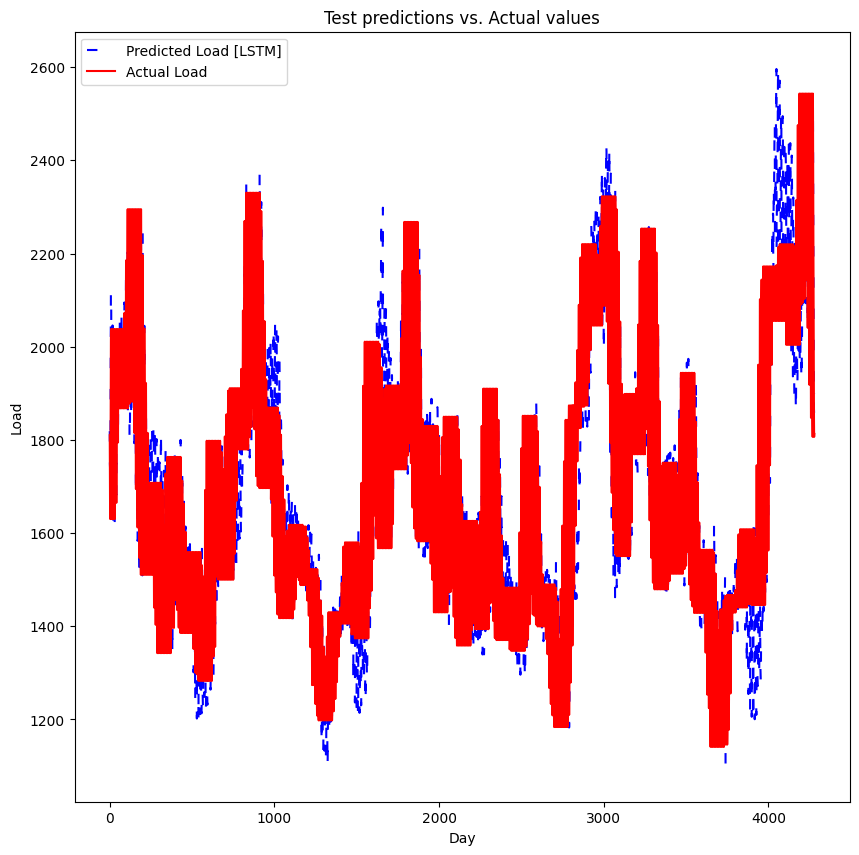

In [ ]:

test_graph = plt.subplots(1,1, figsize=(10,10))[1]
#test_graph.plot(test_predictions, label='Predicted Close [LSTMCell]', color='orange', ls='--')
test_graph.plot(test_predictions, label="Predicted Load [LSTM]", color ='blue', ls=(0, (5, 10)))
test_graph.plot(new_y_test, label='Actual Load', color='red')
test_graph.set_title('Test predictions vs. Actual values')
test_graph.set_xlabel('Day')
test_graph.set_ylabel('Load')
plt.legend()
plt.savefig('LoadLSTM.png')
plt.show()
#files.download("StockLSTM.png")